Now we will train the Inclusive classifier, a combination of the Particle-sequence classifier with the High Level Features.

To run this notebook we used the following configuration:
* *Software stack*: LCG 94 (it has spark 2.3.1)
* *Platform*: centos7-gcc7
* *Spark cluster*: Hadalytic

In [1]:
# Check if Spark Session has been created correctly
spark

In [2]:
# Add the BDL zip file
# sc.addPyFile("/eos/project/s/swan/public/BigDL/bigdl-0.7.0-python-api.zip")

## Load train and test dataset

In [3]:
PATH = "file:///data/cern/"

trainDF = spark.read.format('parquet')\
        .load(PATH + 'trainUndersampled.parquet')\
        .select(['GRU_input', 'HLF_input', 'encoded_label'])
        
testDF = spark.read.format('parquet')\
        .load(PATH + 'testUndersampled.parquet')\
        .select(['GRU_input', 'HLF_input', 'encoded_label'])

In [4]:
trainDF.printSchema()

root
 |-- GRU_input: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)
 |-- HLF_input: vector (nullable = true)
 |-- encoded_label: vector (nullable = true)



## Create the model

In [5]:
# Init analytics zoo
from zoo.common.nncontext import *
sc = init_nncontext("inclusive classifier")

In [6]:
from zoo.pipeline.api.keras.models import Sequential
from zoo.pipeline.api.keras.layers.core import *
from zoo.pipeline.api.keras.layers.torch import Select
from zoo.pipeline.api.keras.layers.normalization import BatchNormalization
from zoo.pipeline.api.keras.layers.recurrent import GRU
from zoo.pipeline.api.keras.engine.topology import Merge

## GRU branch
gruBranch = Sequential() \
            .add(Masking(0.0, input_shape=(801, 19))) \
            .add(GRU(
                output_dim=50,
                return_sequences=True,
                activation='tanh'
            )) \
            .add(Select(1, -1))

## HLF branch
hlfBranch = Sequential() \
            .add(Dropout(0.0, input_shape=(14,)))

## Concatenate the branches
branches = Merge(layers=[gruBranch, hlfBranch], mode='concat')

## Create the model
model = Sequential() \
        .add(branches) \
        .add(BatchNormalization()) \
        .add(Dense(3, activation='softmax'))

creating: createZooKerasSequential
creating: createZooKerasMasking
creating: createZooKerasGRU
creating: createZooKerasSelect
creating: createZooKerasSequential
creating: createZooKerasDropout
creating: createZooKerasMerge
creating: createZooKerasSequential
creating: createZooKerasBatchNormalization
creating: createZooKerasDense


## Create train and valiation RDD

We need to create an RDD of `Sample`, a tuple of the form (`features`, `label`). The two elements of this touple should be `numpy arrays`. 

In [7]:
from bigdl.util.common import Sample
import numpy as np

trainRDD = trainDF.rdd.map(lambda row: Sample.from_ndarray(
    [np.array(row.GRU_input), np.array(row.HLF_input)],
    np.array(row.encoded_label)
))

testRDD = testDF.rdd.map(lambda row: Sample.from_ndarray(
    [np.array(row.GRU_input), np.array(row.HLF_input)],
    np.array(row.encoded_label)
))

In [8]:
# Let's have a look at one element of trainRDD
trainRDD.take(1)

[Sample: features: [JTensor: storage: [ 4.4452043  -1.4459659   0.12834984 ...  0.         28.284271
  -2.0649471 ], shape: [801  19], float, JTensor: storage: [0.01069611 0.03581727 0.6577833  0.00202169 0.07692308 0.
  0.00600872 0.6999402  0.29771337 0.76114357 0.         0.
  0.         0.        ], shape: [14], float], labels: [JTensor: storage: [1. 0. 0.], shape: [3], float]]

We can see that `Sample.feature` is  now composed by the list of 801 particles with 19 features each (`shape=[801 19]`) plus the HLF (`shape=[14]`) and the encoded label (`shape=[3]`).

## Optimizer setup and training

In [10]:
# Set of hyperparameters
numEpochs = 10

# The batch used by BDL must be a multiple of numExecutors * executorCores
# Because data will be equally distibuted inside each executor

workerBatch = 64
# numExecutors = int(sc._conf.get('spark.executor.instances'))
numExecutors = 1
# executorCores = int(sc._conf.get('spark.executor.cores'))
executorCores = 4

BDLbatch = workerBatch * numExecutors * executorCores

In [11]:
# Use Keras model training API to train

from bigdl.optim.optimizer import *
from bigdl.nn.criterion import CategoricalCrossEntropy

model.compile(optimizer='adam', loss=CategoricalCrossEntropy(), metrics=[Loss(CategoricalCrossEntropy())])

creating: createCategoricalCrossEntropy
creating: createCategoricalCrossEntropy
creating: createLoss
creating: createAdam


Let's define a directory to store logs (i.e. train and validation losses) and save models

In [12]:
# name of our application
appName = "InclusiveClassifier"

# Change it! 
logDir = "/data/cern/ZOOlogs"

# Check if there is already an application with the same name 
# and remove it, otherwise logs will be appended to that app
import os
try:
    os.system('rm -rf '+logDir+'/'+appName)
except:
    pass

print("Saving logs to {}".format(logDir+'/'+appName))

Saving logs to /data/cern/ZOOlogs/InclusiveClassifier


In [13]:
# Set tensorboard for model training and validation
model.set_tensorboard(logDir, appName)

We are now ready to launch the training.

**Warnign: During the trainign it would be better to shutdown the Toggle Spark Monitorin Display because each iteration is seen as a spark job, therefore the toggle will try to display everything causing problem to the browser.** 

In [14]:
%%time 
model.fit(x=trainRDD, batch_size=BDLbatch, nb_epoch=numEpochs, validation_data=testRDD, distributed=True)

CPU times: user 28 ms, sys: 28 ms, total: 56 ms
Wall time: 9min 49s


## Plot loss

creating: createTrainSummary
creating: createValidationSummary


<IPython.core.display.Javascript object>


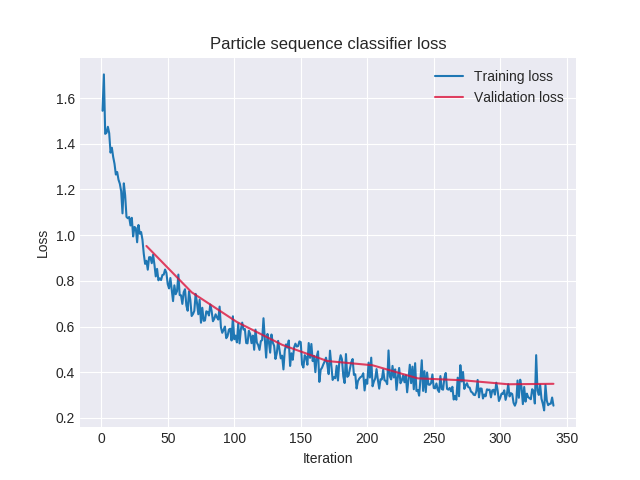

In [15]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib notebook

trainSummary = TrainSummary(log_dir=logDir,app_name=appName)
loss = np.array(trainSummary.read_scalar("Loss"))
valSummary = ValidationSummary(log_dir=logDir,app_name=appName)
val_loss = np.array(valSummary.read_scalar("Loss"))

plt.plot(loss[:,0], loss[:,1], label="Training loss")
plt.plot(val_loss[:,0], val_loss[:,1], label="Validation loss", color='crimson', alpha=0.8)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.title("Particle sequence classifier loss")
plt.show()

## Save the model

In [16]:
modelDir = logDir + '/models'
model.saveModel(
            modelPath = modelDir + '/' + "inclusive" + '.bigdl',
            weightPath = modelDir + '/' + "inclusive" + '.bin',
            over_write = True
)

It is possible to load the model in the following way:
```Python
model = Model.loadModel(modelPath=modelPath+'.bigdl', weightPath=modelPath+'.bin')
```

## Prediction

In [17]:
pred = model.predict(testRDD)

In [18]:
y_pred = np.asarray(pred.collect())
y_true = np.asarray(testDF.select('encoded_label').rdd\
                    .map(lambda row: np.asarray(row.encoded_label)).collect())

In [19]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

<IPython.core.display.Javascript object>


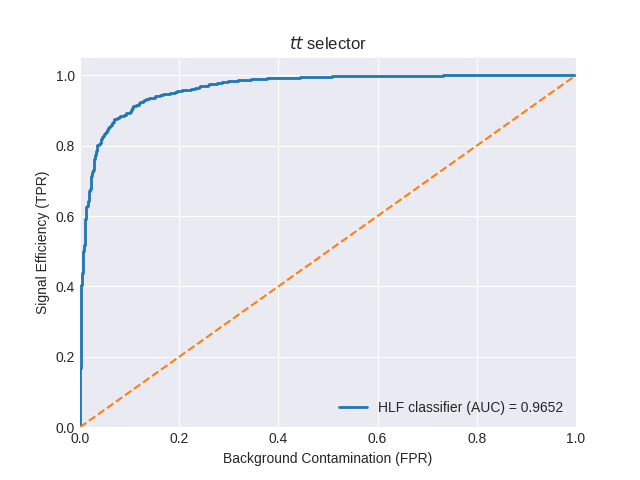

In [20]:
plt.figure()
plt.plot(fpr[0], tpr[0], lw=2, 
         label='HLF classifier (AUC) = %0.4f' % roc_auc[0])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.show()